In [1]:
import lmdb
import matplotlib.pyplot as plt
import pickle
import tifffile
import os
from train_DA import Trainer
from config_manager import TrainDAConfiguration
import tensorflow as tf
from utils.data import get_gt_as_numpy

2024-06-18 15:29:05.227997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 15:29:05.262749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:29:05.262773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:29:05.263989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 15:29:05.270448: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/amarinai/miniconda3/envs/bcfind/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is showing final predictions

In [83]:
import json
domain = "SST"
dataset = "test"

lmdb_dir = "/home/amarinai/DeepLearningThesis/Results/Unet_DA_lowloss/"+ domain+"_"+dataset+"_pred_lmdb"
lmdb_dir_1 = "/home/amarinai/DeepLearningThesis/Results/Unet_DA_lowloss_002/"+ domain+"_"+dataset+"_pred_lmdb"
data = lmdb.open(lmdb_dir, readonly=True)
data_dir = "/home/amarinai/Data/"+ domain+"/Tiff_files/"+dataset.capitalize()
gt_dir = "/home/amarinai/Data/"+ domain+"/GT_files/"+dataset.capitalize()
data1 = lmdb.open(lmdb_dir_1, readonly=True)

#print(json.loads("/home/amarinai/DeepLearningThesis/Results/Unet_DA_lowloss/DoG_checkpoints/BlobDoG_parameters.json"))
#print(json.loads("/home/amarinai/DeepLearningThesis/Results/Unet_DA_lowloss_002/DoG_checkpoints/BlobDoG_parameters.json"))

fx1 = data1.begin()
Y1 = fx1.cursor()
Y1 = Y1.iternext()

"""fx = data.begin()
Y = fx.cursor()
Y = Y.iternext()"""


'fx = data.begin()\nY = fx.cursor()\nY = Y.iternext()'

In [34]:
s=fx1.get("sub_0640_09600_01920__1153_0091_05564.tif".encode())
s.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [94]:
domain = "SST"
dataset = "val"

lmdb_dir_1 = "/home/amarinai/DeepLearningThesis/Results/Unet_DA_lowloss_002/"+ domain+"_"+dataset+"_pred_lmdb"
data = lmdb.open(lmdb_dir_1, readonly=True)

fx1 = data.begin()
Y1 = fx1.cursor()
Y1 = Y1.iternext()

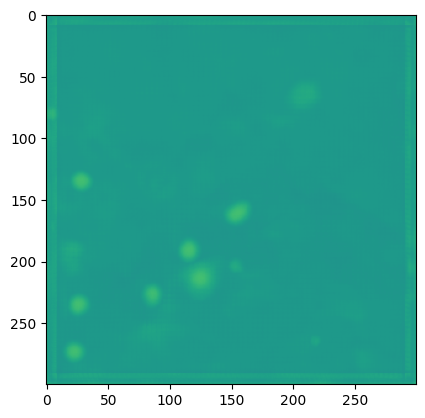

In [97]:
key,  y = next(Y1)
y = pickle.loads(y)
plt.imshow(y.max(0), vmin=0, vmax=255)

(100, 300, 300)
/home/amarinai/Data/SST/GT_files/Test/02400_13600_1000.tif.marker
1 gt_points


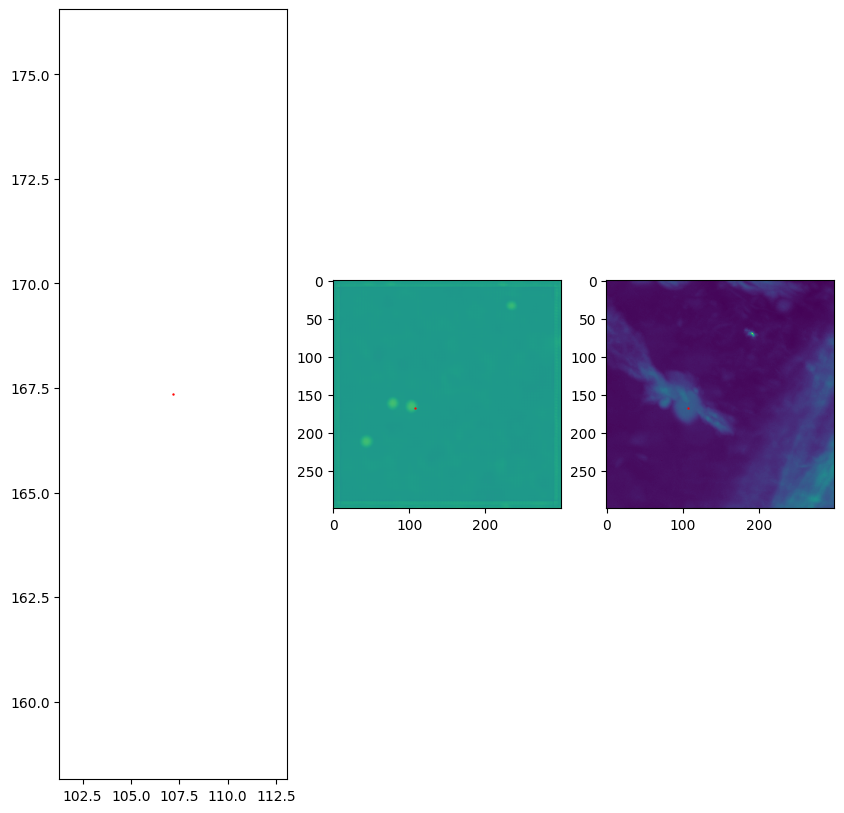

In [93]:
fig, axes = plt.subplots(1,3, figsize=(10,10))
"""key,  y = next(Y)
y = pickle.loads(y)
axes[0].imshow(y.max(0), vmin=0, vmax=255)
"""
key,  y = next(Y1)
y = pickle.loads(y)
axes[1].imshow(y.max(0), vmin=0, vmax=255)
x = tifffile.imread(f"{data_dir}/{key.decode()}")
axes[2].imshow(x.max(0))
print(x.shape)

a = f"{gt_dir}/{key.decode()}"
if domain == "SST":
    a = a.replace(".tif",".tif.marker")
if domain == "CFos":
    a = a.replace(".tiff",".tiff.marker")
a = a.replace("tif.markerf","tiff.marker")

print(a)
gt = get_gt_as_numpy(a)
print(gt.shape[0], "gt_points")

coordinates = gt[:, 1:]
axes[0].scatter(coordinates[:, 1], coordinates[:, 0], c='red', marker='o', s = 0.5)
axes[1].scatter(coordinates[:, 1], coordinates[:, 0], c='red', marker='o', s = 0.4)
axes[2].scatter(coordinates[:, 1], coordinates[:, 0], c='red', marker='o', s = 0.4)

This is using checkpoints results

In [28]:
import itertools
import tensorflow as tf


def predict(input, model):
    if tf.rank(input) == 3:
        input = input[tf.newaxis, ..., tf.newaxis]

    I, J = 8, 8
    for i, j in itertools.product(range(I), range(J)):
        if i == 0 and j == 0:
            x = tf.identity(input)
            continue
        try:
            print("Input shape =", x.shape)
            pred, _ = model(x, training=False)
            break
        except (tf.errors.InvalidArgumentError, ValueError) as e:
            print("Invalid input shape for concat layer. Extracting slice")
            x = tf.slice(
                input,
                [0, 0, 0, 0, 0],
                size=[
                    input.shape[0],
                    input.shape[1] - j,
                    input.shape[2] - i,
                    input.shape[3] - i,
                    input.shape[4],
                ],
            )

            if i == I - 1 and j == J - 1:
                raise e

    pred = tf.sigmoid(tf.squeeze(pred))
    return pred

In [44]:
from utils.models import predict
from utils.data import get_input_tf, get_gt_as_numpy
import numpy as np

def print_predictions(
        tiff_files, marker_files, data_shape, trainer, **preprocessing_kwargs
    ):  
        # UNet predictions
        i=0
        for tiff_file, marker_file in zip(tiff_files, marker_files):
            if i >= 1:
                break
            x = get_input_tf(tiff_file, **preprocessing_kwargs)

            pred = predict(x, trainer.unet).numpy()
            y = get_gt_as_numpy(marker_file)
            fig, axes = plt.subplots(len(tiff_files),2)
            print(x)
            
            print(y)
            
            axes[i, 0].imshow(tf.math.reduce_max(pred,0))
            axes[i, 1].imshow(tf.math.reduce_max(x,0))
            i+=1
            print(i)



Input shape = (1, 100, 300, 300, 1)
tf.Tensor(
[[[0.0071106  0.00665283 0.00585938 ... 0.00946045 0.00863647 0.01037598]
  [0.006073   0.00650024 0.00497437 ... 0.00900269 0.00961304 0.00933838]
  [0.00595093 0.00592041 0.00720215 ... 0.00738525 0.00872803 0.00823975]
  ...
  [0.00576782 0.00643921 0.00610352 ... 0.01019287 0.01107788 0.01119995]
  [0.00561523 0.00582886 0.00656128 ... 0.0105896  0.01062012 0.01092529]
  [0.00582886 0.00643921 0.0065918  ... 0.01123047 0.01147461 0.01065063]]

 [[0.00698853 0.0067749  0.00598145 ... 0.00875854 0.00839233 0.0093689 ]
  [0.00595093 0.00643921 0.00668335 ... 0.00857544 0.00808716 0.00930786]
  [0.00723267 0.00662231 0.00646973 ... 0.00799561 0.00735474 0.00823975]
  ...
  [0.00534058 0.00619507 0.00570679 ... 0.01159668 0.0105896  0.01086426]
  [0.0055542  0.00604248 0.00637817 ... 0.01153564 0.01126099 0.01300049]
  [0.00561523 0.00610352 0.00616455 ... 0.01132202 0.01065063 0.00952148]]

 [[0.00653076 0.00708008 0.00662231 ... 0.0073852

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

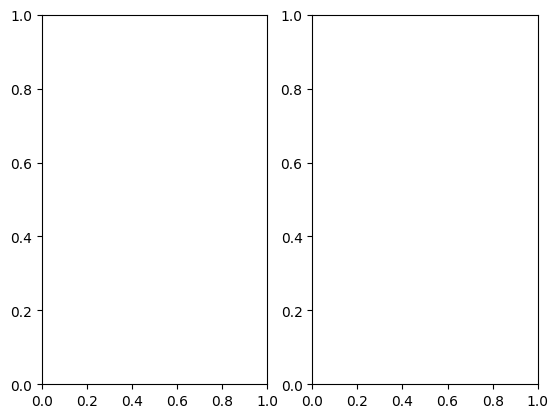

: 

In [45]:
from train_DA import get_inputs_target_paths

model_path = "/home/amarinai/DeepLearningThesis/Results/Unet_DA_long/UNet_checkpoints/saved_model9000/model.tf"
trainer = Trainer()
config_file = "/home/amarinai/DeepLearningThesis/Results/Unet_DA_long/train_config_DA.yaml"
conf = TrainDAConfiguration(config_file)
trainer.build_unet(
                        n_blocks=conf.unet.n_blocks,
                        n_filters=conf.unet.n_filters,
                        k_size=conf.unet.k_size,
                        k_stride=conf.unet.k_stride,
                        dropout=conf.unet.dropout,
                        regularizer=conf.unet.regularizer,
                        model_type=conf.unet.model,
                        lambda_da=conf.unet.lambda_da,
                        squeeze_factor=conf.unet.squeeze_factor,
                        moe_n_experts=conf.unet.moe_n_experts,
                        moe_top_k_experts=conf.unet.moe_top_k_experts,
                        moe_noise=conf.unet.moe_noise,
                        moe_balance_loss=conf.unet.moe_balance_loss,
                    )

trainer.unet.load_weights(model_path).expect_partial()

test_on_target  = False
if not test_on_target:
            data_conf = conf.source
else:
            data_conf = conf.target
test_tiff_files, test_marker_files = get_inputs_target_paths(
            data_conf.test_tif_dir, data_conf.test_gt_dir
        )
data_dir = "/home/amarinai/Data/CFos/Tiff_files/Test"
fnames = os.listdir(data_dir)
print_predictions(
            tiff_files=test_tiff_files,
            marker_files=test_marker_files,
            data_shape=data_conf.shape,
            trainer=trainer,
            **conf.preproc,
        )




